<a href="https://colab.research.google.com/github/Pope-Ray22/Ray_Johnson/blob/master/Final_2020_Masters_Write_up_FIN22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ray Johnson

## 2020 MDI Masters Project Write Up

### Advisors: Erik Einarsson, Bruce Pitman, Kristofer Reyes

#### 8/10/2020

# Introduction

Autonomous REsearch System (ARES) is a novel research technique that has had a large impact in material science as we know it. This autonomous robot has allowed for researchers to transition from traditional time consuming experiments that may result in two or fewer experiments per day to hundreds of conducted experiments. Each new set of experiments is incorporated in designing the future set of experiments without human intervention. The development of ARES has allowed for materials to be analyzed at the 100&nbsp;nm length scale level. This is where specific desired material properties can be controlled the best, allowing for optimal growth of experimental materials from metal seeders and substrate materials.

The carbon nanotube field has seen an explosion of controlled development due to the ARES technique. Carbon nanotubes serve many applications in the real world in the field of pharmaceuticals, aviation, and computer development due to its many desirable properties such as strength, stiffness, thermal and electrical conductivity. Using  ARES to synthesize carbon nanotubes allows us to isolate from the large parameter space of temperature, pressure, and gas composition while using in-situ characterization methods that would lead to optimal grow-th of this material iterated over hundreds of experiments.

Traditional methods such as chemical vapor deposition heats an entire wafer of substrate to a specific high temperature resulting in high cost as well as making it difficult to measure the characterization signal at the same time due to heat loss. Resolution of *in-situ* Raman is not the greatest quality, Thus we want to attempt to de-noise and smooth the signal to get a better understanding on what parameters optimize the signal. For this process silicon pillars with metal seeders are hit with a laser causing a chemical reaction with the carbon environment allowing for the formation of the carbon nanotube. Simultaneously, the laser is reflecting back into the spectrometer and a spectrum is taking  from that exact location. Reaction occurs in 3 second time steps resulting in the silicon crystal vibrations producing a Raman peak typically seen at 520&nbsp;cm$^{-1}$. As temperature increases these vibrations of the silicon crystal becomes amplified and the bonds get softer allowing for the peak position to downward shift at a specific temperature of the pillar. The equation used to find the temp of a particular location of the heated substrate is;

$$E(T)\epsilon = {\frac {E(T)\Delta N_{w}}{m(T)}}$$

The objective of this research is to design Gaussian process that can be used to map amplitude output values to Raman peak position at specific time steps with a high level of certainty. We tested a variety of model parameters as well as using two types of Gaussian process, partial paralell GP and independent GP. We wanted to see the impact of using multiple GPs to predict spectra. Finally, compare plots and precent errors to determine optimal parameter values.

### Initializing Code

In [ ]:
# Imported Libraries 
import pandas as pd 
import urllib
import numpy as np
import matplotlib as plt
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import scipy as scipy
from scipy import optimize
from matplotlib.ticker import AutoMinorLocator
from matplotlib import gridspec
import matplotlib.ticker as ticker
%matplotlib inline

# ----- make nice figures -----
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 150
mpl.rcParams['figure.figsize'] = (4,4)
from cycler import cycler
COLORS = ['#F00D2C', '#242482', '#0071BE', '#4E8F00', '#553C67', '#DA5319', '#242482']
default_cycler = cycler(color= 'r''b')
plt.rc('axes', prop_cycle=default_cycler) 
# -----------------------------

### Data import from excel file into a data frame

In [ ]:
df = pd.read_csv('silicon_fits_3.csv',)

## Indexing, Columns and Data Values

In [ ]:
index = df.index
columns = df.columns
values = df.values
print(columns)
print(index)
type(values)

Index(['Time (s)', 'shape 1', 'pos 1', 'width 1', 'ampl 1', 'shape 2', 'pos 2',
       'width 2', 'ampl 2', 'shape 3', 'pos 3', 'width 3', 'ampl 3', 'shape 4',
       'pos 4', 'width 4', 'ampl 4', 'shape 5', 'pos 5', 'width 5', 'ampl 5',
       'shape 6', 'pos 6', 'width 6', 'ampl 6', 'shape 7', 'pos 7', 'width 7',
       'ampl 7', 'shape 8', 'pos 8', 'width 8', 'ampl 8'],
      dtype='object')
RangeIndex(start=0, stop=108, step=1)


numpy.ndarray

In [ ]:
pd.set_option('Display.max_columns', None)
pd.set_option('Display.max_rows', None)

## Data table for 10 rows

This data set is a condensed version of what is typically seen from ARES data organization. This view allows us to isolate row by row the amplitudes along with their corresponding peak positions at a given time. There are a total of 8 amplitude rows, with the shape of peak and width fixed at lorentz and 20.0&nbsp;cm$^{-1}$ respectively. The total time goes up to 353 seconds in 3 second increments and peak positions are seen from 495&nbsp;cm$^{-1}$ to 525&nbsp;cm$^{-1}$.

In [ ]:
df.head(10)

,Time (s),shape 1,pos 1,width 1,ampl 1,shape 2,pos 2,width 2,ampl 2,shape 3,pos 3,width 3,ampl 3,shape 4,pos 4,width 4,ampl 4,shape 5,pos 5,width 5,ampl 5,shape 6,pos 6,width 6,ampl 6,shape 7,pos 7,width 7,ampl 7,shape 8,pos 8,width 8,ampl 8
0,0,lorentz,495,20,0.000000,lorentz,497.5,20,0.000000,NaN,500,NaN,0.000000,NaN,502.5,NaN,0.000000,NaN,517.5,NaN,700.261137,NaN,520,NaN,176.967909,NaN,522.5,NaN,0.000000,NaN,525,NaN,0.000000
1,3,lorentz,495,20,0.000000,lorentz,497.5,20,0.000000,NaN,500,NaN,0.000000,NaN,502.5,NaN,0.000000,NaN,517.5,NaN,642.006188,NaN,520,NaN,222.041040,NaN,522.5,NaN,0.000000,NaN,525,NaN,0.000000
2,6,lorentz,495,20,0.000000,lorentz,497.5,20,0.000000,NaN,500,NaN,0.000000,NaN,502.5,NaN,0.000000,NaN,517.5,NaN,596.459811,NaN,520,NaN,269.051036,NaN,522.5,NaN,0.000000,NaN,525,NaN,0.000000
3,9,lorentz,495,20,334.896749,lorentz,497.5,20,949.711285,lorentz,500,20.0,563.872491,lorentz,502.5,20.0,0.000000,lorentz,517.5,20.0,0.000000,lorentz,520,20.0,307.838047,NaN,522.5,NaN,281.424106,NaN,525,NaN,165.738202
4,13,lorentz,495,20,375.536625,lorentz,497.5,20,822.458136,lorentz,500,20.0,848.291680,lorentz,502.5,20.0,0.000000,lorentz,517.5,20.0,0.000000,lorentz,520,20.0,239.686423,NaN,522.5,NaN,403.133902,NaN,525,NaN,102.469775
5,16,lorentz,495,20,276.641676,lorentz,497.5,20,765.363320,lorentz,500,20.0,983.847068,lorentz,502.5,20.0,180.816743,lorentz,517.5,20.0,0.000000,lorentz,520,20.0,0.000000,NaN,522.5,NaN,196.595369,NaN,525,NaN,418.748374
6,19,lorentz,495,20,603.972099,lorentz,497.5,20,777.886182,lorentz,500,20.0,699.122134,lorentz,502.5,20.0,0.000000,lorentz,517.5,20.0,0.000000,lorentz,520,20.0,265.127921,NaN,522.5,NaN,337.959346,NaN,525,NaN,158.595541
7,23,lorentz,495,20,477.184091,lorentz,497.5,20,940.038947,lorentz,500,20.0,716.926398,lorentz,502.5,20.0,0.000000,lorentz,517.5,20.0,0.000000,NaN,520,NaN,0.000000,NaN,522.5,NaN,0.000000,NaN,525,NaN,344.658562
8,26,lorentz,495,20,601.800816,lorentz,497.5,20,885.252701,lorentz,500,20.0,584.324468,lorentz,502.5,20.0,0.000000,lorentz,517.5,20.0,0.000000,lorentz,520,20.0,98.440619,NaN,522.5,NaN,362.574494,NaN,525,NaN,289.583386
9,29,lorentz,495,20,477.119901,lorentz,497.5,20,840.986938,lorentz,500,20.0,795.225667,lorentz,502.5,20.0,0.000000,lorentz,517.5,20.0,0.000000,lorentz,520,20.0,101.678222,NaN,522.5,NaN,283.761012,NaN,525,NaN,336.910488


In [ ]:
Time = np.array(index)

## Parameter Variables

We used two types of Gaussian process regressors to make predictions of the data, one being partial parallel Gaussian process and the last one being independent Gaussian process. Using the RBF kernel as my function we made initial guesses on the uncertainty and length scale for each column. We split the training vs. testing data into 3 different groups with training data at 20, 50, and 80 points respectively. In addition we tested the effect of changing peak width starting with a width of 8&nbsp;cm$^{-1}$, 10&nbsp;cm$^{-1}$, and 15&nbsp;cm$^{-1}$. For our last variable we varied the length scale within the kernels provided using 3, 5, and 10.


# Designing hyper parameter for partial parallel Gaussian Process

In [ ]:
#Kernel 1 - A1
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process import GaussianProcessRegressor

#Model A
sigma_0 = 900   #Initial uncertainty 
sigma_W = 100 #Initial noise variance 
length_scale = 10 #Initial length scale guess

kernelAA = sigma_0**2*RBF(length_scale, length_scale_bounds = (10,1000))
modelA = GaussianProcessRegressor(kernel = kernelAA, alpha = (sigma_W**2)/np.var(df.loc[0:19,['ampl 1']]), normalize_y = True)
modelA.fit(Time[0:20,np.newaxis], df.loc[0:19,['ampl 1']])

print('Hyper Parameter for Amplitude 1 PPGP ' + str (modelA.kernel_))

Hyper Parameter for Amplitude 1 PPGP 2.75**2 * RBF(length_scale=10)


#### Steps repeated for all 8 columns for each variable change.

In [ ]:
#Kernel 1 - A2
#Model B

sigma_0 = 1700   #Initial uncertainty 
sigma_W = 100 #Initial noise variance 
length_scale = 10 #Initial length scale guess

kernelBB = sigma_0**2*RBF(length_scale, length_scale_bounds = (10,2000))
modelB = GaussianProcessRegressor(kernel = kernelBB, alpha = (sigma_W**2)/np.var(df.loc[0:19,['ampl 2']]), normalize_y = True)
modelB.fit(Time[0:20,np.newaxis], df.loc[0:19,['ampl 2']])

print('Hyper Parameter for Amplitude 2 PPGP ' + str (modelB.kernel_))

Hyper Parameter for Amplitude 2 PPGP 19**2 * RBF(length_scale=20.1)


In [ ]:
#Kernel 1 - A3
#Model C

sigma_0 = 1100   #Initial uncertainty 
sigma_W = 100 #Initial noise variance 
length_scale = 10 #Initial length scale guess

kernelCC = sigma_0**2*RBF(length_scale, length_scale_bounds = (10,1300))
modelC = GaussianProcessRegressor(kernel = kernelCC, alpha = (sigma_W**2)/np.var(df.loc[0:19,['ampl 3']]), normalize_y = True)

modelC.fit(Time[0:20,np.newaxis], df.loc[0:19,['ampl 3']])

print('Hyper Parameter for Amplitude 3 PPGP ' + str (modelC.kernel_))

Hyper Parameter for Amplitude 3 PPGP 7.67**2 * RBF(length_scale=10)


In [ ]:
#Kernel 1 - A4
#Model D

sigma_0 = 400   #Initial uncertainty 
sigma_W = 100 #Initial noise variance 
length_scale = 1 #Initial length scale guess

kernelDD = sigma_0**2*RBF(length_scale, length_scale_bounds = (1,500))
modelD = GaussianProcessRegressor(kernel = kernelDD, alpha = (sigma_W**2)/np.var(df.loc[0:19,['ampl 4']]), normalize_y = True)
modelD.fit(Time[0:20,np.newaxis], df.loc[0:19,['ampl 4']])

print('Hyper Parameter for Amplitude 4 PPGP ' + str (modelD.kernel_))

Hyper Parameter for Amplitude 4 PPGP 0.00316**2 * RBF(length_scale=500)


In [ ]:
#Kernel 1 - A5
#Model E
sigma_0 = 700   #Initial uncertainty 
sigma_W = 100 #Initial noise variance 
length_scale = 10 #Initial length scale guess

kernelEE = sigma_0**2*RBF(length_scale, length_scale_bounds = (10,800))
modelE = GaussianProcessRegressor(kernel = kernelEE, alpha = (sigma_W**2)/np.var(df.loc[0:19,['ampl 5']]), normalize_y = True)
modelE.fit(Time[0:20,np.newaxis], df.loc[0:19,['ampl 5']])

print('Hyper Parameter for Amplitude 5 PPGP ' + str(modelE.kernel_))

Hyper Parameter for Amplitude 5 PPGP 4.84**2 * RBF(length_scale=10)


In [ ]:
#Kernel 1 - A6
#Model F

sigma_0 = 500   #Initial uncertainty 
sigma_W = 100 #Initial noise variance 
length_scale = 10 #Initial length scale guess

kernelFF = sigma_0**2*RBF(length_scale, length_scale_bounds = (10,600))
modelF = GaussianProcessRegressor(kernel = kernelFF, alpha = (sigma_W**2)/np.var(df.loc[0:19,['ampl 6']]), normalize_y = True)
modelF.fit(Time[0:20,np.newaxis], df.loc[0:19,['ampl 6']])

print('Hyper Parameter for Amplitude 6 PPGP ' + str(modelF.kernel_))

Hyper Parameter for Amplitude 6 PPGP 0.00316**2 * RBF(length_scale=61.9)


In [ ]:
#Kernel 1 - A7
#Model G

sigma_0 = 700   #Initial uncertainty 
sigma_W = 100 #Initial noise variance 
length_scale = 10 #Initial length scale guess

kernelGG = sigma_0**2*RBF(length_scale, length_scale_bounds = (10,800))
modelG = GaussianProcessRegressor(kernel = kernelGG, alpha = (sigma_W**2)/np.var(df.loc[0:19,['ampl 7']]), normalize_y = True)
modelG.fit(Time[0:20,np.newaxis], df.loc[0:19,['ampl 7']])

print('Hyper Parameter for Amplitude 7 PPGP ' + str(modelG.kernel_))

Hyper Parameter for Amplitude 7 PPGP 1.08**2 * RBF(length_scale=10)


In [ ]:
#Kernel 1 - A8
#Model H

sigma_0 = 600   #Initial uncertainty 
sigma_W = 50 #Initial noise variance 
length_scale = 1 #Initial length scale guess

kernelHH = sigma_0**2*RBF(length_scale, length_scale_bounds = (1,600))
modelH = GaussianProcessRegressor(kernel = kernelHH, alpha = (sigma_W**2)/np.var(df.loc[0:19,['ampl 8']]), normalize_y = True)
modelH.fit(Time[0:20,np.newaxis], df.loc[0:19,['ampl 8']])

print('Hyper Parameter for Amplitude 8 PPGP ' + str(modelH.kernel_))

Hyper Parameter for Amplitude 8 PPGP 1.85**2 * RBF(length_scale=14.4)


This amplitude 1 column was trained on the first 20 data points while using a length scale of 10.

#### Averaging calculated hyper parameters

In [ ]:
# MEan hypers for amplitutde
Uncertainties_A = (316,316,316,113,316,316,316,316)
Length_A = (10,10,10,1,10,10,10,10,1)
print('Average Uncertainty Value ' + str(np.mean(Uncertainties_A)))
print('Average Length Scale Value ' + str(np.mean(Length_A)))

Average Uncertainty Value 290.625
Average Length Scale Value 8.0


## Partial parallel Gaussian process shared kernel

In [ ]:
#Averaged position hyper parameters with optimizer

sigma_0 = 290.625   #Initial uncertainty 
sigma_W = 100 #Initial noise variance 
length_scale = 8 #Initial length scale guess
f_0 = 0 # inital mean

kernelAA = sigma_0**2*RBF(length_scale, length_scale_bounds = (8, 2000))

modelA = GaussianProcessRegressor(kernel = kernelAA, alpha = (sigma_W**2)/np.var(df.loc[0:19,['ampl 1']]), normalize_y = True, optimizer = None)
modelB = GaussianProcessRegressor(kernel = kernelAA, alpha = (sigma_W**2)/np.var(df.loc[0:19,['ampl 2']]), normalize_y = True, optimizer = None)
modelC = GaussianProcessRegressor(kernel = kernelAA, alpha = (sigma_W**2)/np.var(df.loc[0:19,['ampl 3']]), normalize_y = True, optimizer = None)
modelD = GaussianProcessRegressor(kernel = kernelAA, alpha = (sigma_W**2)/np.var(df.loc[0:19,['ampl 4']]), normalize_y = True, optimizer = None)
modelE = GaussianProcessRegressor(kernel = kernelAA, alpha = (sigma_W**2)/np.var(df.loc[0:19,['ampl 5']]), normalize_y = True, optimizer = None)
modelF = GaussianProcessRegressor(kernel = kernelAA, alpha = (sigma_W**2)/np.var(df.loc[0:19,['ampl 6']]), normalize_y = True, optimizer = None)
modelG = GaussianProcessRegressor(kernel = kernelAA, alpha = (sigma_W**2)/np.var(df.loc[0:19,['ampl 7']]), normalize_y = True, optimizer = None)
modelH = GaussianProcessRegressor(kernel = kernelAA, alpha = (sigma_W**2)/np.var(df.loc[0:19,['ampl 8']]), normalize_y = True, optimizer = None)

modelA.fit(Time[0:20,np.newaxis], df.loc[0:19,['ampl 1']])
modelB.fit(Time[0:20,np.newaxis], df.loc[0:19,['ampl 2']])
modelC.fit(Time[0:20,np.newaxis], df.loc[0:19,['ampl 3']])
modelD.fit(Time[0:20,np.newaxis], df.loc[0:19,['ampl 4']])
modelE.fit(Time[0:20,np.newaxis], df.loc[0:19,['ampl 5']])
modelF.fit(Time[0:20,np.newaxis], df.loc[0:19,['ampl 6']])
modelG.fit(Time[0:20,np.newaxis], df.loc[0:19,['ampl 7']])
modelH.fit(Time[0:20,np.newaxis], df.loc[0:19,['ampl 8']])

# Predictions at time step 300 - for Amplitude 

prediction_A = np.zeros(8)
error_A = np.zeros(8)

prediction_A[0], error_A[0] = modelA.predict([[300]], return_std = True)
prediction_A[1], error_A[1] = modelB.predict([[300]], return_std = True)
prediction_A[2], error_A[2] = modelC.predict([[300]], return_std = True)
prediction_A[3], error_A[3] = modelD.predict([[300]], return_std = True)
prediction_A[4], error_A[4] = modelE.predict([[300]], return_std = True)
prediction_A[5], error_A[5] = modelF.predict([[300]], return_std = True)
prediction_A[6], error_A[6] = modelG.predict([[300]], return_std = True)
prediction_A[7], error_A[7] = modelH.predict([[300]], return_std = True)

print(prediction_A)
print(error_A)

[424.71121105 690.207174   608.55218338  31.88722745  96.93635683
 142.1545435  238.18083678 265.42939939]
[61765.63757123 93896.25533688 81780.49047278 15830.94319444
 67233.33997435 30739.74553418 42959.64314543 47757.01500304]


Using the new optimized hyper parameters we calculated for each column and averaged them to get one set of hyper parameters. This is then shared as one optimized kernel seen here as `kernelAA`. Modeling the GPs off one specific kernel we can then make predictions at any time stamp and see how close we are. This is seen for the variables `prediction_A` and `error_A`. 

# Formation of comparable plots for partial parallel GP

- Time vs. Amplitude

- Position vs. Amplitude

- Percent Error

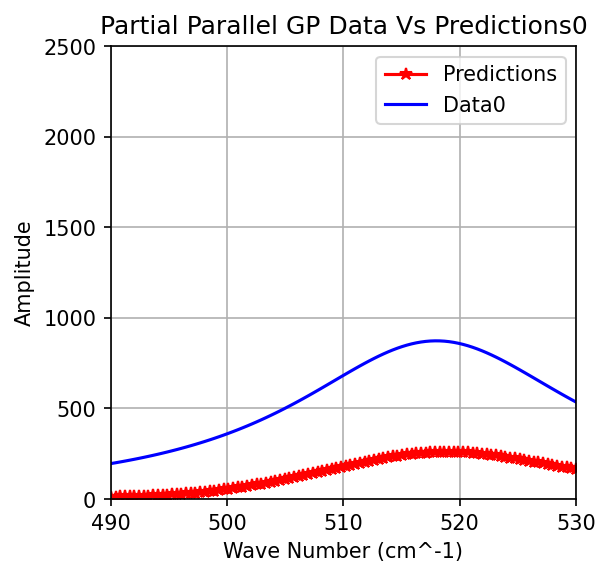

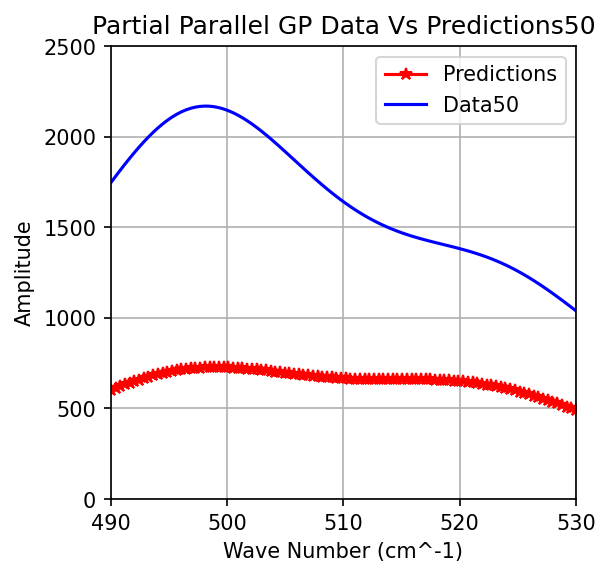

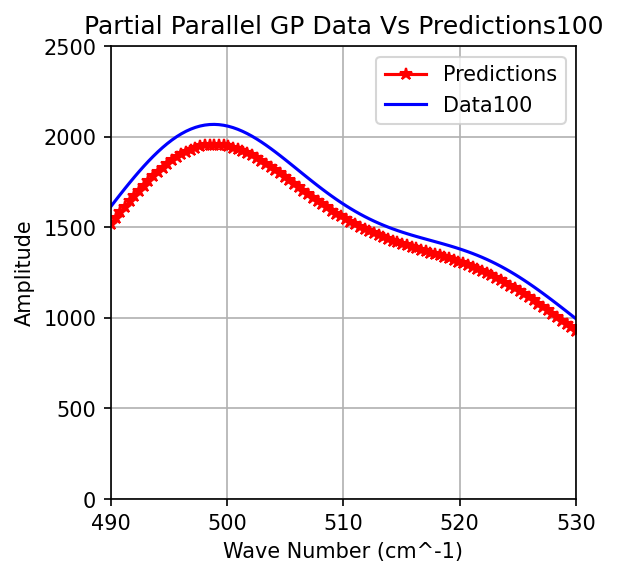

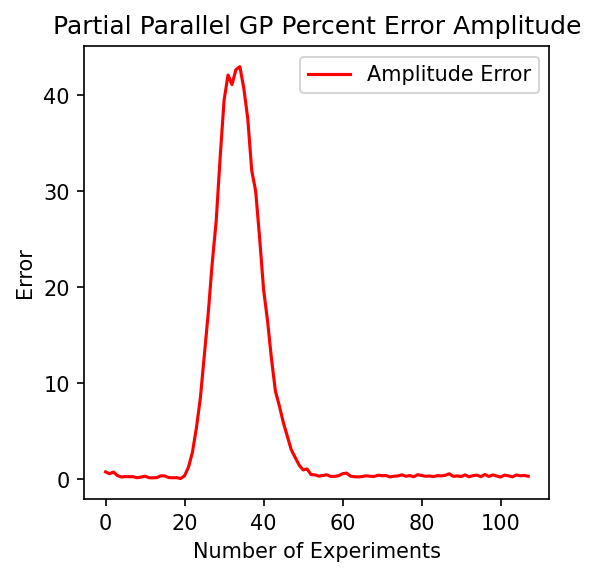

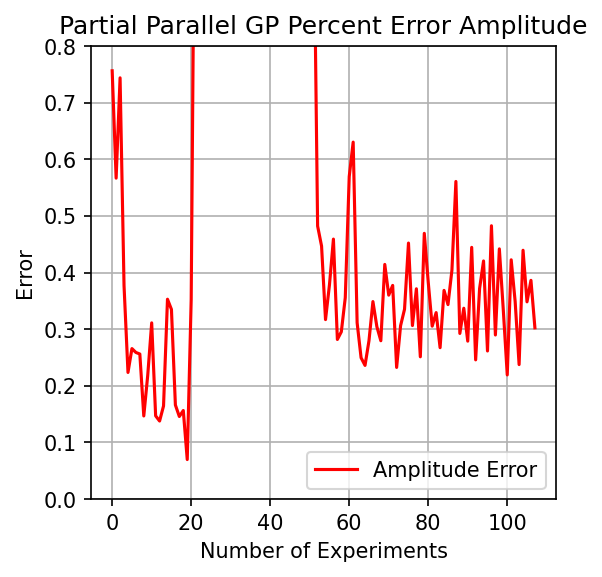

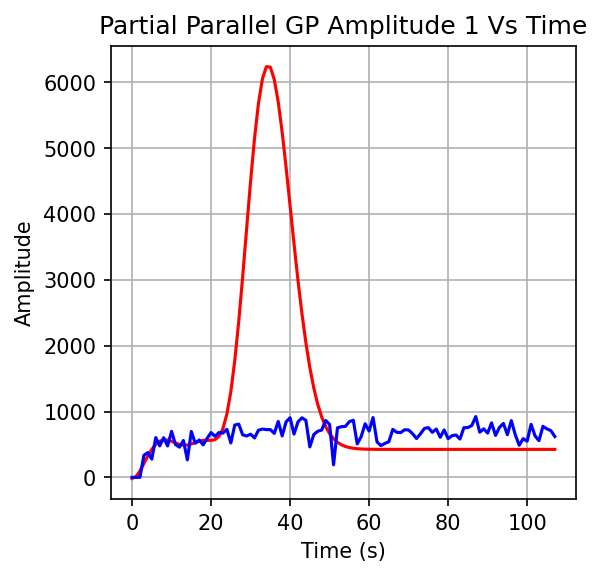

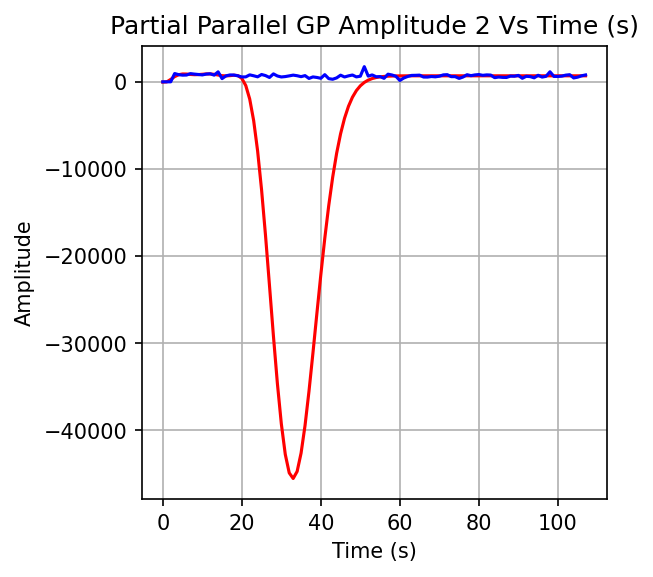

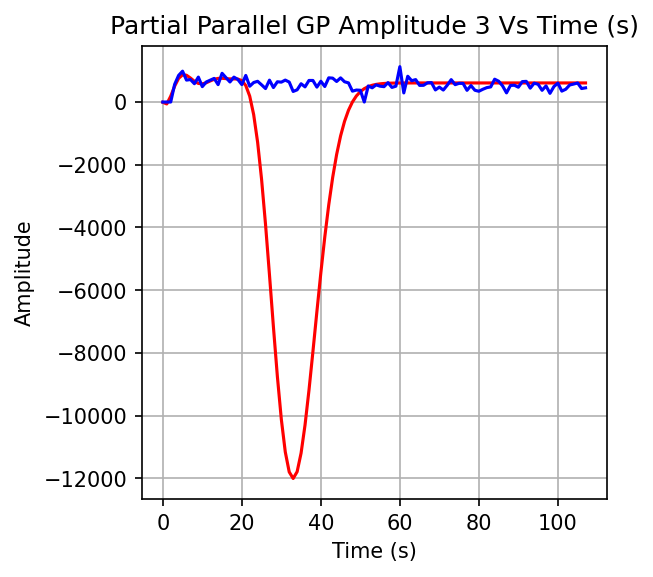

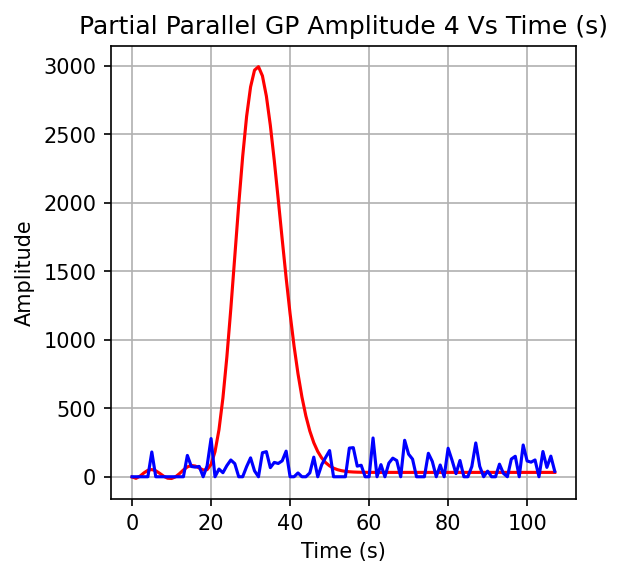

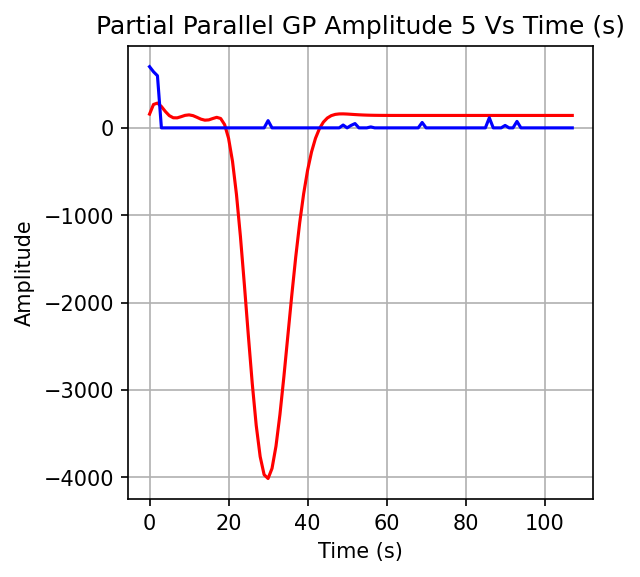

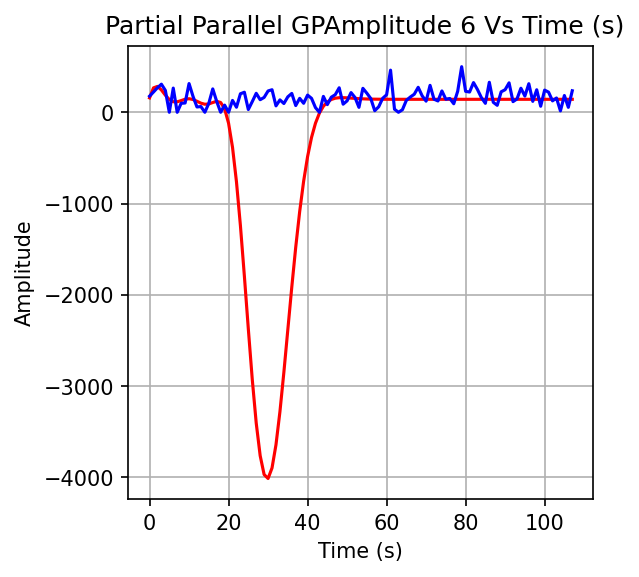

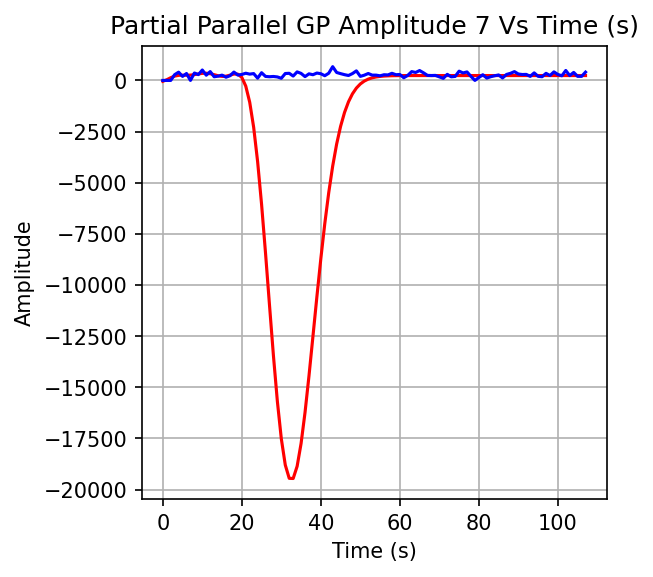

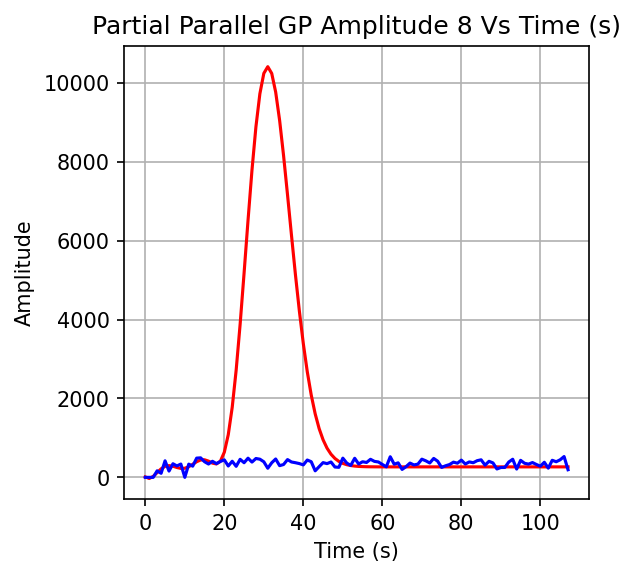

In [ ]:
errorAmp_1 = np.zeros(len(Time))

x_plot = np.linspace(490,530,100)
y_plot = np.zeros(len(x_plot))

prediction_A = np.zeros([len(Time), 8])

for i,T in enumerate (Time):

    prediction_A[i,0] = modelA.predict([[T]])
    prediction_A[i,1] = modelB.predict([[T]])
    prediction_A[i,2] = modelC.predict([[T]])
    prediction_A[i,3] = modelD.predict([[T]])
    prediction_A[i,4] = modelF.predict([[T]])
    prediction_A[i,5] = modelF.predict([[T]])
    prediction_A[i,6] = modelG.predict([[T]])
    prediction_A[i,7] = modelH.predict([[T]])

    Position_D = list(df.loc[i,['pos 1','pos 2','pos 3','pos 4','pos 5','pos 6','pos 7','pos 8']])

    Ampl_D = list(df.loc[i,['ampl 1','ampl 2','ampl 3','ampl 4','ampl 5','ampl 6','ampl 7','ampl 8']])
    
    def Lorentz (x, Position, Amplitude):
        return Amplitude*15**2/((x-Position)**2+(15)**2)

    
    #2 vectors of data

    errorAmp_1[i] = np.linalg.norm(Ampl_D - prediction_A[i,:])/np.linalg.norm(Ampl_D)
    #errorPos_1[i] = np.linalg.norm(Position_D - Prediction_P)/np.linalg.norm(Position_D)
    
    # % plots every 50 points
    if i % 50 ==0:
    
        plt.figure()
        y_plot = np.zeros(len(x_plot))
        
        for j in range (8):
            y_plot=y_plot + Lorentz(x_plot,Position_D[j],prediction_A[i,j])

        plt.plot(x_plot, y_plot, label = 'Predictions', marker = "*")
        
        y_plot = np.zeros(len(x_plot))
        
        for j in range (8):
            y_plot=y_plot + Lorentz(x_plot,Position_D[j],Ampl_D[j])

        plt.plot(x_plot, y_plot, label = 'Data'+ str (i))
        plt.legend()
        plt.title('Partial Parallel GP Data Vs Predictions' + str(i))
        plt.xlabel('Wave Number (cm^-1)')
        plt.ylabel('Amplitude')
        plt.xlim(490, 530)
        plt.ylim(0,2500)
        plt.grid()
        plt.savefig("7DataVsPredictions_10LS_50TD_15WD_65TS.png") 
        
plt.figure()    
plt.plot(Time, errorAmp_1, label = 'Amplitude Error')
plt.title('Partial Parallel GP Percent Error Amplitude')
plt.xlabel('Number of Experiments')
plt.ylabel('Error')
plt.legend()
plt.grid
plt.savefig('6Error_fullVsTime_3LS_50TD_10WD.png')        

plt.figure()    
plt.plot(Time, errorAmp_1, label = 'Amplitude Error')
plt.title('Partial Parallel GP Percent Error Amplitude')
plt.xlabel('Number of Experiments')
plt.ylabel('Error')
plt.legend()
plt.ylim(0,0.8)
plt.grid()
plt.savefig('6Error_limitedVsTime_3LS_50TD_15WD.png')

plt.figure()
plt.plot(Time, prediction_A[:,0], label = 'Predictions')
plt.plot(Time, df.loc[:,'ampl 1'], label = 'Data')
plt.title('Partial Parallel GP Amplitude 1 Vs Time')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid()
plt.savefig('5Amp1VsTime_3LS_50TD_15WD.png')

plt.figure()
plt.plot(Time, prediction_A[:,1], label = 'Predictions')
plt.plot(Time, df.loc[:,'ampl 2'], label = 'Data')
plt.title('Partial Parallel GP Amplitude 2 Vs Time (s)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid()
plt.savefig('5Amp2VsTime_3LS_50TD_15WD.png')

plt.figure()
plt.plot(Time, prediction_A[:,2], label = 'Predictions')
plt.plot(Time, df.loc[:,'ampl 3'], label = 'Data')
plt.title('Partial Parallel GP Amplitude 3 Vs Time (s)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid()
plt.savefig('5Amp3VsTime_3LS_50TD_15WD.png')

plt.figure()
plt.plot(Time, prediction_A[:,3], label = 'Predictions')
plt.plot(Time, df.loc[:,'ampl 4'], label = 'Data')
plt.title('Partial Parallel GP Amplitude 4 Vs Time (s)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid()
plt.savefig('5Amp4VsTime_3LS_50TD_15WD.png')

plt.figure()
plt.plot(Time, prediction_A[:,4], label = 'Predictions')
plt.plot(Time, df.loc[:,'ampl 5'], label = 'Data')
plt.title('Partial Parallel GP Amplitude 5 Vs Time (s)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid()
plt.savefig('5Amp5VsTime_3LS_50TD_15WD.png')

plt.figure()
plt.plot(Time, prediction_A[:,5], label = 'Predictions')
plt.plot(Time, df.loc[:,'ampl 6'], label = 'Data')
plt.title(' Partial Parallel GPAmplitude 6 Vs Time (s)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid()
plt.savefig('5Amp6VsTime_3LS_50TD_15WD.png')

plt.figure()
plt.plot(Time, prediction_A[:,6], label = 'Predictions')
plt.plot(Time, df.loc[:,'ampl 7'], label = 'Data')
plt.title('Partial Parallel GP Amplitude 7 Vs Time (s)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid()
plt.savefig('5Amp7VsTime_3LS_50TD_15WD.png')

plt.figure()
plt.plot(Time, prediction_A[:,7], label = 'Predictions')
plt.plot(Time, df.loc[:,'ampl 8'], label = 'Data')
plt.title('Partial Parallel GP Amplitude 8 Vs Time (s)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid()
plt.savefig('5Amp8VsTime_3LS_50TD_15WD.png')

These plots produced are based on the first 20 training data points. The Position vs. Time plots are the first three plots produed showing how well the fits are when comparing the data with the predictions. All of the variations of training data showed the same pattern for these plots. The fits are off initially right after the training data point is hit then gradually improves in fitting. The Amplitude Vs. Time plots also follow a similar pattern when varying the number of training data points. These plots show a large error once predictions begin which is seen a lot when fitting polynomials. We believe this is due to the Gaussian process trying to smooth out while still fitting the data.
        
Using the Lorentz peak equation seen in the function "Lorentz" from above we were able to fix the peaks for this set of plots at 15&nbsp;cm$^{-1}$. To measure how well that value effected the plots we can look at the first initial peak from the first plot of the set. A typical Raman silicon Peak should be seen at 520&nbsp;cm$^{-1}$, the predicted peak was seen at that same values and trend away from 520&nbsp;cm$^{-1}$ as the width decreased.

# Independent Gaussian process

For the independent GP we used each individual hyper parameter calculated for each column and created 8 different kernels  for each gaussian process. The same set of parameters were tested for this process as was for the partial parallel GP. Most of steps from the partial parallel GPs were replicated for the independent GP with the biggest difference being that all GPs were designed to use individual kernels.

- The code below uses the perscribed parameters:
    - Length Scale = 3
    - Width = 15&nbsp;cm$^{-1}$
    - Trained Data = 80 Data Points


### Hyper Parameters for IGP

In [ ]:
#Kernel 1 - A1
import matplotlib.pyplot as plt
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process import GaussianProcessRegressor
#Model A

sigma_0 = 900   #Initial uncertainty 
sigma_W = 100 #Initial noise variance 
length_scale = 3 #Initial length scale guess

kernelA = sigma_0**2*RBF(length_scale, length_scale_bounds = (3,100))
modelAA = GaussianProcessRegressor(kernel = kernelA, alpha = (sigma_W**2)/np.var(df.loc[0:79,['ampl 1']]), normalize_y = True)
modelAA.fit(Time[0:80,np.newaxis], df.loc[0:79,['ampl 1']])

print(modelAA.kernel_)

3.64**2 * RBF(length_scale=40.4)


#### Hyper parameters for independent class

In [ ]:
#Kernel 1 - A2
#Model B

sigma_0 = 1700   #Initial uncertainty 
sigma_W = 100 #Initial noise variance 
length_scale = 3 #Initial length scale guess

kernelB = sigma_0**2*RBF(length_scale, length_scale_bounds = (3,2000))
modelBA = GaussianProcessRegressor(kernel = kernelB, alpha = (sigma_W**2)/np.var(df.loc[0:79,['ampl 2']]), normalize_y = True)
modelBA.fit(Time[0:80,np.newaxis], df.loc[0:79,['ampl 2']])


print(modelBA.kernel_)

0.00316**2 * RBF(length_scale=2e+03)


In [ ]:
#Kernel 1 - A3

#Model C

sigma_0 = 1100   #Initial uncertainty 
sigma_W = 100 #Initial noise variance 
length_scale = 3 #Initial length scale guess

kernelC = sigma_0**2*RBF(length_scale, length_scale_bounds = (3,1200))
modelCA = GaussianProcessRegressor(kernel = kernelC, alpha = (sigma_W**2)/np.var(df.loc[0:79,['ampl 3']]), normalize_y = True)
modelCA.fit(Time[0:80,np.newaxis], df.loc[0:79,['ampl 3']])

print(modelCA.kernel_)

0.00316**2 * RBF(length_scale=1.2e+03)


In [ ]:
#Kernel 1 - A4
#Model D

sigma_0 = 400   #Initial uncertainty 
sigma_W = 100 #Initial noise variance 
length_scale = 3 #Initial length scale guess

kernelD = sigma_0**2*RBF(length_scale, length_scale_bounds = (3,600))
modelDA = GaussianProcessRegressor(kernel = kernelD, alpha = (sigma_W**2)/np.var(df.loc[0:79,['ampl 4']]), normalize_y = True)
modelDA.fit(Time[0:80,np.newaxis], df.loc[0:79,['ampl 4']])

print(modelDA.kernel_)

0.00316**2 * RBF(length_scale=600)


In [ ]:
#Kernel 1 - A5
#Model E

sigma_0 = 700   #Initial uncertainty 
sigma_W = 100 #Initial noise variance 
length_scale = 3 #Initial length scale guess

kernelE = sigma_0**2*RBF(length_scale, length_scale_bounds = (3,1000))
modelEA = GaussianProcessRegressor(kernel = kernelE, alpha = (sigma_W**2)/np.var(df.loc[0:79,['ampl 5']]), normalize_y = True)
modelEA.fit(Time[0:80,np.newaxis], df.loc[0:79,['ampl 5']])

print(modelEA.kernel_)

0.00316**2 * RBF(length_scale=1e+03)


In [ ]:
#Kernel 1 - A6
#Model F
sigma_0 = 500   #Initial uncertainty 
sigma_W = 100 #Initial noise variance 
length_scale = 3 #Initial length scale guess

kernelF = sigma_0**2*RBF(length_scale, length_scale_bounds = (3,600))
modelFA = GaussianProcessRegressor(kernel = kernelF, alpha = (sigma_W**2)/np.var(df.loc[0:79,['ampl 6']]), normalize_y = True)
modelFA.fit(Time[0:80,np.newaxis], df.loc[0:79,['ampl 6']])

print(modelFA.kernel_)

0.00316**2 * RBF(length_scale=600)


In [ ]:
#Kernel 1 - A7
#Model G

sigma_0 = 700   #Initial uncertainty 
sigma_W = 100 #Initial noise variance 
length_scale = 3 #Initial length scale guess

kernelG = sigma_0**2*RBF(length_scale, length_scale_bounds = (3,800))
modelGA = GaussianProcessRegressor(kernel = kernelG, alpha = (sigma_W**2)/np.var(df.loc[0:79,['ampl 7']]), normalize_y = True)
modelGA.fit(Time[0:80,np.newaxis], df.loc[0:79,['ampl 7']])

print(modelGA.kernel_)

0.00316**2 * RBF(length_scale=800)


In [ ]:
#Kernel 1 - A8
#Model H

sigma_0 = 600   #Initial uncertainty 
sigma_W = 100 #Initial noise variance 
length_scale = 3 #Initial length scale guess

kernelH = sigma_0**2*RBF(length_scale, length_scale_bounds = (3,600))
modelHA = GaussianProcessRegressor(kernel = kernelH, alpha = (sigma_W**2)/np.var(df.loc[0:79,['ampl 8']]), normalize_y = True)
modelHA.fit(Time[0:80,np.newaxis], df.loc[0:79,['ampl 8']])

print(modelHA.kernel_)

1.16**2 * RBF(length_scale=15.3)


# Independent GP individualized kernels

In [ ]:
import matplotlib.pyplot as plt
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process import GaussianProcessRegressor

kernelA = sigma_0**2*RBF(length_scale, length_scale_bounds = (3, 990))
kernelB = sigma_0**2*RBF(length_scale, length_scale_bounds = (3, 2000))
kernelC = sigma_0**2*RBF(length_scale, length_scale_bounds = (3, 2000))
kernelD = sigma_0**2*RBF(length_scale, length_scale_bounds = (3, 300))
kernelE = sigma_0**2*RBF(length_scale, length_scale_bounds = (3, 300))
kernelF = sigma_0**2*RBF(length_scale, length_scale_bounds = (3, 300))
kernelG = sigma_0**2*RBF(length_scale, length_scale_bounds = (3, 300))
kernelH = sigma_0**2*RBF(length_scale, length_scale_bounds = (3, 300))

modelAA = GaussianProcessRegressor(kernel = kernelA, alpha = (sigma_W**2)/np.var(df.loc[0:79,['ampl 1']]), normalize_y = True, optimizer = None)
modelBA = GaussianProcessRegressor(kernel = kernelB, alpha = (sigma_W**2)/np.var(df.loc[0:79,['ampl 2']]), normalize_y = True, optimizer = None)
modelCA = GaussianProcessRegressor(kernel = kernelC, alpha = (sigma_W**2)/np.var(df.loc[0:79,['ampl 3']]), normalize_y = True, optimizer = None)
modelDA = GaussianProcessRegressor(kernel = kernelD, alpha = (sigma_W**2)/np.var(df.loc[0:79,['ampl 4']]), normalize_y = True, optimizer = None)
modelEA = GaussianProcessRegressor(kernel = kernelE, alpha = (sigma_W**2)/np.var(df.loc[0:79,['ampl 3']]), normalize_y = True, optimizer = None)
modelFA = GaussianProcessRegressor(kernel = kernelF, alpha = (sigma_W**2)/np.var(df.loc[0:79,['ampl 6']]), normalize_y = True, optimizer = None)
modelGA = GaussianProcessRegressor(kernel = kernelG, alpha = (sigma_W**2)/np.var(df.loc[0:79,['ampl 7']]), normalize_y = True, optimizer = None)
modelHA = GaussianProcessRegressor(kernel = kernelH, alpha = (sigma_W**2)/np.var(df.loc[0:79,['ampl 8']]), normalize_y = True, optimizer = None)

modelAA.fit(Time[0:80,np.newaxis], df.loc[0:79,['ampl 1']])
modelBA.fit(Time[0:80,np.newaxis], df.loc[0:79,['ampl 2']])
modelCA.fit(Time[0:80,np.newaxis], df.loc[0:79,['ampl 3']])
modelDA.fit(Time[0:80,np.newaxis], df.loc[0:79,['ampl 4']])
modelEA.fit(Time[0:80,np.newaxis], df.loc[0:79,['ampl 3']])
modelFA.fit(Time[0:80,np.newaxis], df.loc[0:79,['ampl 6']])
modelGA.fit(Time[0:80,np.newaxis], df.loc[0:79,['ampl 7']])
modelHA.fit(Time[0:80,np.newaxis], df.loc[0:79,['ampl 8']])

# Predictions at time step 300 - for Amplitude 

prediction_A = np.zeros(8)
error_A = np.zeros(8)

prediction_A[0], error_A[0] = modelAA.predict([[300]], return_std = True)
prediction_A[1], error_A[1] = modelBA.predict([[300]], return_std = True)
prediction_A[2], error_A[2] = modelCA.predict([[300]], return_std = True)
prediction_A[3], error_A[3] = modelDA.predict([[300]], return_std = True)
prediction_A[4], error_A[4] = modelEA.predict([[300]], return_std = True)
prediction_A[3], error_A[3] = modelFA.predict([[300]], return_std = True)
prediction_A[6], error_A[6] = modelGA.predict([[300]], return_std = True)
prediction_A[7], error_A[7] = modelHA.predict([[300]], return_std = True)

print(prediction_A)
print(error_A)


[628.91639948 656.52353992 572.17985847 150.83930193 572.17985847
   0.         274.57513963 340.77666119]
[115528.10930157 145286.63291171 120539.01406555  58746.98499102
 120539.01406555      0.          73046.82797537  68785.68146131]


Every GP model is running through specifically designed kernels based on the specific columns values of amplitude.

### For loop for independent GP - Percent error, Time Vs Amplitude, Peak Position Vs Amplitude.

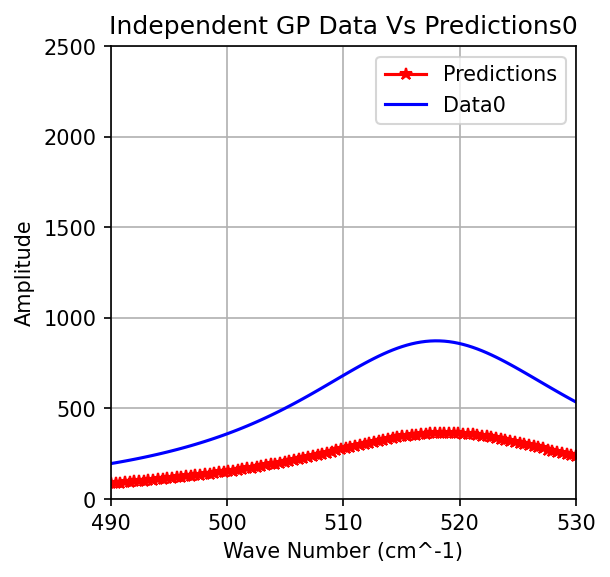

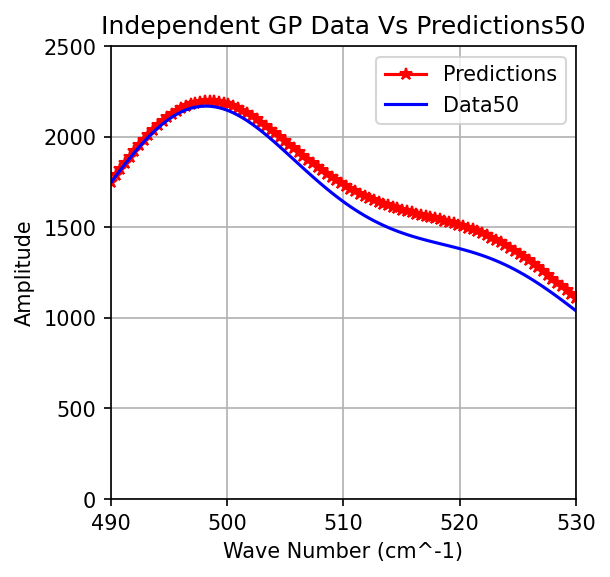

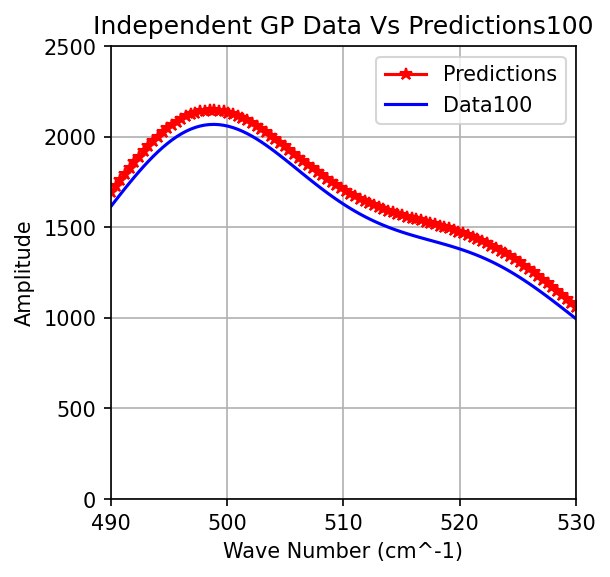

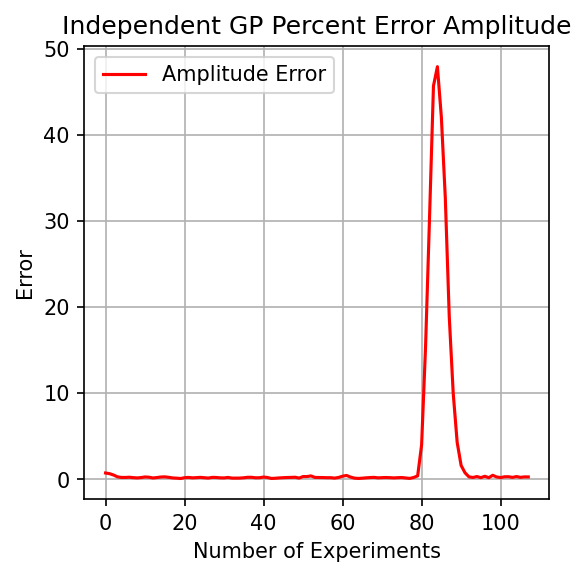

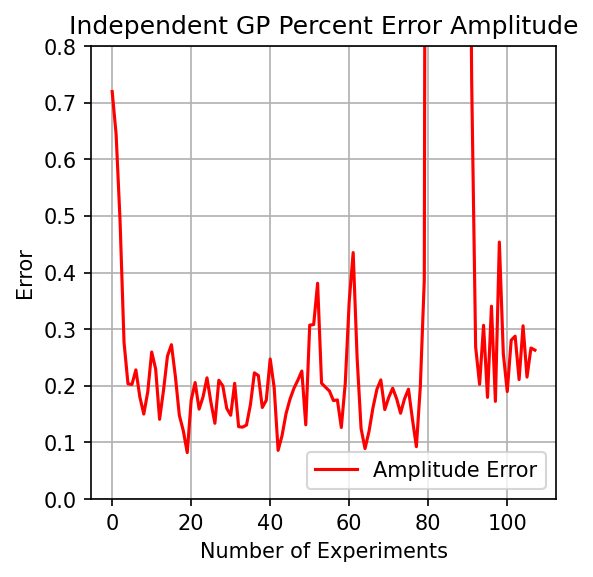

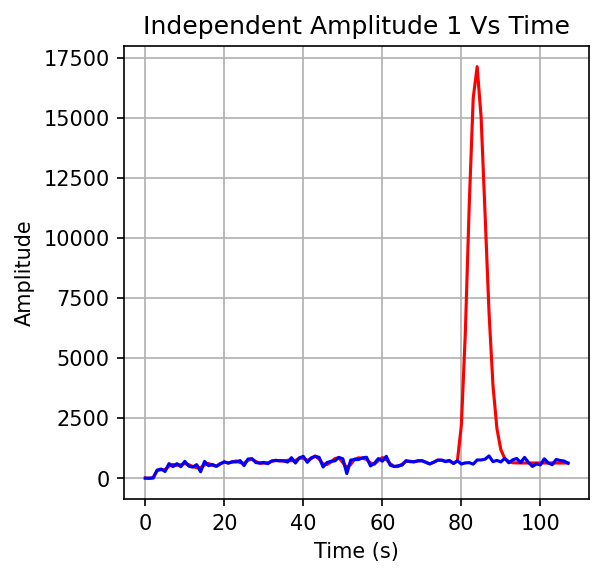

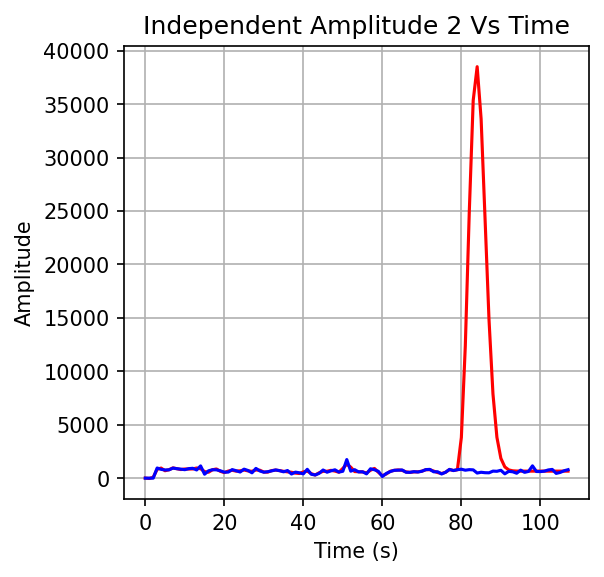

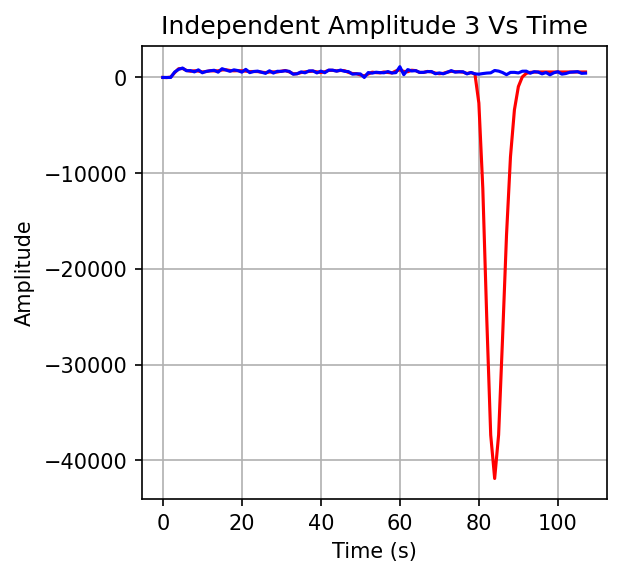

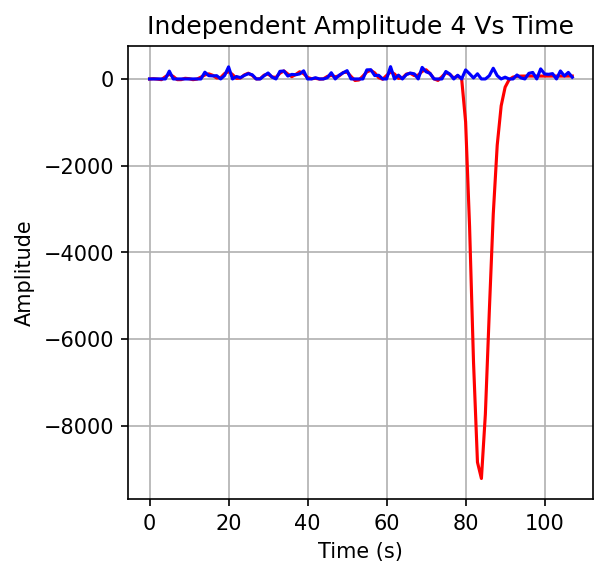

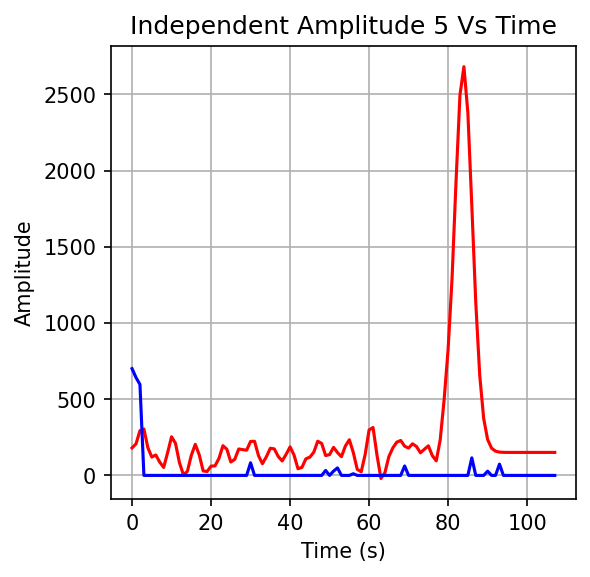

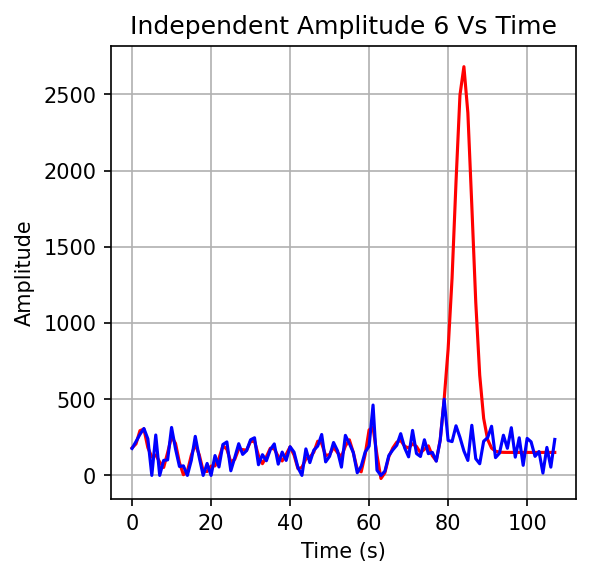

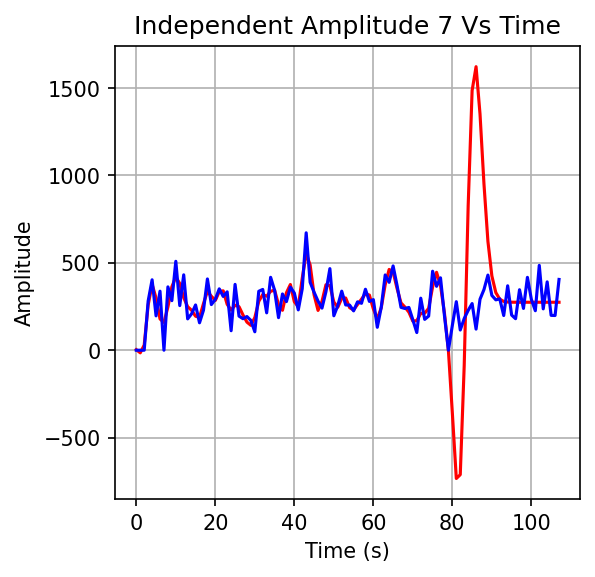

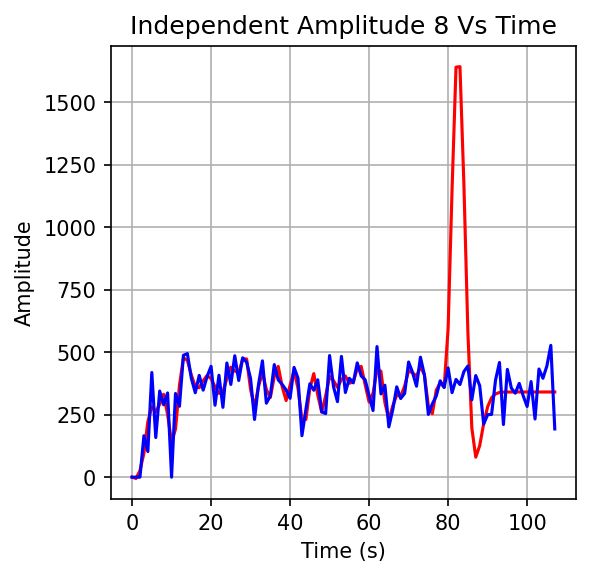

In [ ]:
# Independent GP

errorAmp_2 = np.zeros(len(Time))

# X_plot = range of amplitude values
x_plot = np.linspace(490,530,100)
y_plot = np.zeros(len(x_plot))

prediction_A = np.zeros([len(Time), 8])

for i,T in enumerate (Time):
    
    prediction_A[i,0] = modelAA.predict([[T]])
    prediction_A[i,1] = modelBA.predict([[T]])
    prediction_A[i,2] = modelCA.predict([[T]])
    prediction_A[i,3] = modelDA.predict([[T]])
    prediction_A[i,4] = modelFA.predict([[T]])
    prediction_A[i,5] = modelFA.predict([[T]])
    prediction_A[i,6] = modelGA.predict([[T]])
    prediction_A[i,7] = modelHA.predict([[T]])

    Position_D = list(df.loc[i,['pos 1','pos 2','pos 3','pos 4','pos 5','pos 6','pos 7','pos 8']])

    Ampl_D = list(df.loc[i,['ampl 1','ampl 2','ampl 3','ampl 4','ampl 5','ampl 6','ampl 7','ampl 8']])

    def Lorentz (x, Position, Amplitude):
        return Amplitude*15**2/((x-Position)**2+(15)**2)

    errorAmp_2[i] = np.linalg.norm(Ampl_D - prediction_A[i,:])/np.linalg.norm(Ampl_D)
    
    # % plots every 50 points
    if i % 50 ==0:
    
        plt.figure()
        y_plot = np.zeros(len(x_plot))
        
        for j in range (8):
            y_plot=y_plot + Lorentz(x_plot,Position_D[j],prediction_A[i,j])

        plt.plot(x_plot, y_plot, label = 'Predictions', marker = "*")
        
        y_plot = np.zeros(len(x_plot))
        
        for j in range (8):
            y_plot=y_plot + Lorentz(x_plot,Position_D[j],Ampl_D[j])

        plt.plot(x_plot, y_plot, label = 'Data'+ str (i))
        plt.legend()
        plt.title('Independent GP Data Vs Predictions' + str(i))
        plt.xlabel('Wave Number (cm^-1)')
        plt.ylabel('Amplitude')
        plt.xlim(490, 530)
        plt.ylim(0,2500)
        plt.grid()
        plt.savefig('2IND_DataVsPredictions_10LS_20TD_15WD.png')

plt.figure()    
plt.plot(Time, errorAmp_2, label = 'Amplitude Error')
plt.title('Independent GP Percent Error Amplitude')
plt.xlabel('Number of Experiments')
plt.ylabel('Error')
plt.legend()
plt.grid()
plt.savefig('2IND_Error_fullVsTime_3LS_20TD_10WD.png')        

plt.figure()    
plt.plot(Time, errorAmp_2, label = 'Amplitude Error')
plt.title('Independent GP Percent Error Amplitude')
plt.xlabel('Number of Experiments')
plt.ylabel('Error')
plt.legend()
plt.ylim(0,0.8)
plt.grid()
plt.savefig('3IND_Error_limitedVsTime_3LS_20TD_10WD.png')

plt.figure()
plt.plot(Time, prediction_A[:,0], label = 'Predictions')
plt.plot(Time, df.loc[:,'ampl 1'], label = 'Data')
plt.title('Independent Amplitude 1 Vs Time')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid()
plt.savefig('3IND_Amp1VsTime_3LS_20TD_10WD.png')

plt.figure()
plt.plot(Time, prediction_A[:,1], label = 'Predictions')
plt.plot(Time, df.loc[:,'ampl 2'], label = 'Data')
plt.title('Independent Amplitude 2 Vs Time')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid()
plt.savefig('3IND_Amp2VsTime_3LS_20TD_10WD.png')

plt.figure()
plt.plot(Time, prediction_A[:,2], label = 'Predictions')
plt.plot(Time, df.loc[:,'ampl 3'], label = 'Data')
plt.title('Independent Amplitude 3 Vs Time')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid()
plt.savefig('3IND_Amp3VsTime_3LS_20TD_10WD.png')

plt.figure()
plt.plot(Time, prediction_A[:,3], label = 'Predictions')
plt.plot(Time, df.loc[:,'ampl 4'], label = 'Data')
plt.title('Independent Amplitude 4 Vs Time')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid()
plt.savefig('3IND_Amp4VsTime_3LS_20TD_10WD.png')

plt.figure()
plt.plot(Time, prediction_A[:,4], label = 'Predictions')
plt.plot(Time, df.loc[:,'ampl 5'], label = 'Data')
plt.title('Independent Amplitude 5 Vs Time')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid()
plt.savefig('3IND_Amp5VsTime_3LS_20TD_10WD.png')

plt.figure()
plt.plot(Time, prediction_A[:,5], label = 'Predictions')
plt.plot(Time, df.loc[:,'ampl 6'], label = 'Data')
plt.title('Independent Amplitude 6 Vs Time')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid()
plt.savefig('3IND_Amp6VsTime_3LS_20TD_10WD.png')

plt.figure()
plt.plot(Time, prediction_A[:,6], label = 'Predictions')
plt.plot(Time, df.loc[:,'ampl 7'], label = 'Data')
plt.title('Independent Amplitude 7 Vs Time')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid()
plt.savefig('3IND_Amp7VsTime_3LS_20TD_10WD.png')

plt.figure()
plt.plot(Time, prediction_A[:,7], label = 'Predictions')
plt.plot(Time, df.loc[:,'ampl 8'], label = 'Data')
plt.title('Independent Amplitude 8 Vs Time')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid()
plt.savefig('3IND_Amp8VsTime_3LS_20TD_10WD.png')


# Results and Discussion



## Training data plots

https://drive.google.com/file/d/14FPeQ1eFOG4IJSLw58DMNCvIu3oyJHyi/view?usp=sharing

For all plots

- Length Scale = 5
- Width Fixed = 8

Time measured against the actual data in blue as well as the predicted values in red illustrate good fits up to the end of the trained data for all training data sets. The initial spike in missed predictions occur right as the trained data mark is hit but returns back within range of the expected amplitude values in all cases for both the independent and partial parallel Gaussian processes.

## Length scale plots

https://drive.google.com/file/d/1cPa0Wzyr5wTT6vg6IeILZonDbsjPeVTN/view?usp=sharing

For all plots

- Trained Data fixed = 50
- Width Fixed = 15&nbsp;cm$^{-1}$

Length scale was viewed at 3 different values from 3, 5, & 10 to see how that could effect fitting. As length scale decreased the predictions made on the testing data were closer when compared to the larger length scales. At a length scale of 10 you can see large misfits of amplitudes corresponding with the predictions. This lets us know that the optimal values for length scale should be small but not too small to avoid overfitting. As seen in the variation of the training data, the position vs amplitude fits increased in accuracy as time went on. This phenomenon was viewed in both independent and partial parallel processes.


## Width plots

https://drive.google.com/file/d/1EXSrDaZ66oUWxzzd1SLKhqgM6Bjl7W9T/view?usp=sharing

### Lorentz peak equation:

$$\phi(x) = A {\frac {1}{(x-v^{2})+\sigma^{2}}}$$



For all plots:
- Length scale = 3
- Training data = 80

Testing on peak widths of 8, 10 and 15 we wanted to see what width could be used to produce a predicted peak position at 520&nbsp;cm$^{-1}$. Using the Lorentz equation where A = amplitude, v = position, x = wave number, and sigma = peak width. We were able to substitute the sigma value and determine which width produced the wave number closes to 520&nbsp;cm$^{-1}$. We were able to identify the ideal peak width at 15&nbsp;cm$^{-1}$ for both partial parallel and independent GPs


### Percent Error plots

https://drive.google.com/file/d/1RTH11y6XVilBnWb0f5tPKqmho95U_Jne/view?usp=sharing

Relative percent error was taking at every parameter change done in all experiments plotting the number of experiments against its respective error values. This made it possible to identify the optimal parameters for the partial parallel and independent GP to predict Raman spectra of silicon. The bottom 3 graphs correspond to the independent gaussian process also at 20, 50 and 80% training data points respectively.All plots exhibited a large increase in error as predictions are being made on the testing data initially. However, the range in which the percent error returns to a similar trend, allows us to differentiate between the plots. Calculating the difference in percent error for each of the training data values it is shown that the less training data the regressor is given the higher the difference in relative percent error. As the training data approaches 80% of the data with a length scale of 3 and peak width of 15&nbsp;cm$^{-1}$, the data will result in the most accurate predictions when using the partial parallel gaussian processor.

# Conclusion

Using Partial parallel and independent gaussian processing we are able to find the optimal parameters needed to predict specific peak position at a given time. 
This will allow us to connect peak position to specific temperatures that can now be controlled to reach the optimal objective of growing ideal carbon nanotubes.
Based on these findings building a strong partial parallel gaussian regressor with a small length scale of 3, a peak width of 15&nbsp;cm$^{-1}$  and training models on roughly 80% of the data we can make solid predictions of where a peak Is positioned.
The data is fairly static thus, It would be interesting to apply this technique to more dynamic data in the future.
We could possibly see better results in the case of a more structured dynamic data set and also explore different kernels as well.


# References

1. https://www.materialstoday.com/nanomaterials/news/combinatorial-approach-carbon-nanotube-catalyst/
2. https://www.dvidshub.net/news/212550/afrl-system-revolutionizes-research-process
3. https://medium.com/dunder-data/selecting-subsets-of-data-in-pandas-6fcd0170be9c
4. https://royalsocietypublishing.org/doi/pdf/10.1098/rsta.2004.1447
5. https://www.nature.com/articles/npjcompumats201631